# Scoring Elaticsearch Results
### LMI Capstone Team
### Summer Chambers | Steve Morris | Kaleb Shikur

## Setup

In [68]:
import pandas as pd
import numpy as np
import json
import math
from statistics import mode
from sklearn.metrics import ndcg_score, f1_score, average_precision_score
from matplotlib import pyplot as plt
import seaborn as sns

In [69]:
metadata_url = "https://mikeanders.org/data/CMS/CMS-2018-0101-0001/CMS-1701-P%20Comment%20MetaData.csv"
data = pd.read_csv(metadata_url, usecols=range(0,36))[:468] #ignore last few columns and blank rows at end of csv 
data = data.rename(columns=lambda x: x.strip()) #strip whitespace from columns

In [70]:
data10 = data.fillna(0) #fill NaN with 0

section_cols = data10.columns[3:] 
data10[section_cols] = data10[section_cols].replace(["Y"], 1) #replace Y with 1 in approriate columns
data11 = data10.copy()
section_cols1  = data11.columns[3:] 
data11[section_cols1] = np.where((data11[section_cols1]  != 1), 0, data11[section_cols1])

# Combining columns for index matching: (A6b, A6b.1, = A6b),  (C3b, C3b.1'= C3b) ('A7', 'A7.1', 'A7.2', = A7b, a7c),  (F = F2, F3)

data11['A6b'] = (data11['A6b'] + data11['A6b.1'])
data11['A6b'] = data11['A6b'].replace(2,1)
data11['C3b'] = (data11['C3b'] + data11['C3b.1'])
data11['C3b'] = data11['C3b'].replace(2,1)
data11['A7'] = (data11['A7'] + data11['A7.1'] + data11['A7.2'])
data11['A7'] = data11['A7'].replace(2,1)
data11['A7'] = data11['A7'].replace(3,1)

data11 = data11.drop(['A6b.1', 'C3b.1', 'A7.1', 'A7.2'], axis=1)
data11.Name = [name.split('DRAFT-')[1].split('-')[0] for name in data11.Name]
data11 = data11.rename(columns=lambda x: x.lower())
section_cols1 = data11.columns[3:]

In [71]:
data11

,name,organization name / submitter name,submitter state,a2,a3,a4b,a4c,a5b,a5c,a5d,...,d3c,d3d,d4,e2,e3,e4,e5,e6,e7,f
0,0002,Erick Meleher,NC,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0003,Mayank Shah,IL,0,0,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0
2,0004,Mayank Shah,IL,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0005,Morey Menacker,NJ,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0006,Todd Rapoza,MA,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
463,0465,Morehouse Choice Accountable Care Organization...,GA,1,1,0,0,1,0,1,...,1,0,0,0,0,0,0,1,0,0
464,0466,Liberty ACO,TX,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
465,0467,Washington State Hospital Association,WA,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
466,0468,Think Whole Person Healthcare,NE,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
truth_dict = {} # initiate dict
for i, name in enumerate(data11.name): # iterate through Comment Names
    dict1 = {col:data11[col].iloc[i] for col in section_cols1} # locate this row's values for each column
    list1 = [key for key,value in dict1.items() if value==1] # create list of matching sections for this row
    truth_dict[name] = list1 # add Comment Name and list of matching sections to dict

In [6]:
with open("unique_comments2018.json") as f:
    unique_comments2018 = json.load(f)

In [7]:
unique_data = data11.loc[data11['name'].isin(unique_comments2018.keys())]

In [8]:
unique_truth_dict = {} # initiate dict
for i, name in enumerate(unique_data.name): # iterate through Comment Names
    dict1 = {col:unique_data[col].iloc[i] for col in section_cols1} # locate this row's values for each column
    list1 = [key for key,value in dict1.items() if value==1] # create list of matching sections for this row
    unique_truth_dict[name] = list1 # add Comment Name and list of matching sections to dict

In [9]:
dump = json.dumps(unique_truth_dict)
f = open('unique_truth_dict.json','w')
f.write(dump)
f.close()

In [10]:
#define true rule section names
truth_keys = list(section_cols1)
truth_keys = [key1.lower() for key1 in truth_keys]

## Headers Unique Index Testing

In [33]:
with open('match_header_results.json') as f:
    unique_header_results = json.load(f)

In [34]:
#tranlate ES keys to true rule section names, MAINTAINING ORDER
for key, value in unique_header_results.items():
    value_list = []
    for val_idx, score in value.items():
        for true_key in truth_keys:
            if true_key in val_idx and true_key not in value_list: 
                value_list.append(true_key)
        unique_header_results[key]={true_key: score for (val_idx, score), true_key in zip(value.items(),value_list)}     

### Normalize scores (divide by mean)

In [35]:
normalized_results = {}
for comment_idx, result in unique_header_results.items():
    score_mean = np.mean(list(result.values()))
    score_dict = {}
    for rule_idx, score in result.items():
        score_dict[rule_idx] = score/score_mean
    normalized_results[comment_idx] = score_dict

In [36]:
normalized_lists = {comment_idx:list(score_dict.items()) for comment_idx, score_dict in normalized_results.items()}

### Merge results for same comment chunks

In [37]:
merged_results = {}
for key in unique_truth_dict.keys():
    merged_list = []
    for comment_idx, result_list in normalized_lists.items():
        if key in comment_idx:
            merged_list.extend(result_list)
    merged_results[key] = merged_list
merged_results = {comment_idx:sorted(result, key=lambda x:x[1], reverse=True) for comment_idx, result in merged_results.items()}

In [38]:
for comment_idx, tup_list in merged_results.items():
    score_dict = {}
    for tup in tup_list:
        if tup[0] in score_dict.keys():
            score_dict[tup[0]] += tup[1]
        else:
            score_dict[tup[0]] = tup[1]
    merged_results[comment_idx] = score_dict

In [39]:
merged_results = {comment_idx:dict(sorted(result.items(), key = lambda x:x[1], reverse=True))\
                  for comment_idx, result in merged_results.items()}

### Sklearn

In [40]:
#create truth dict with values equal to sparse array length=29, binary
unique_truth_dict_all = unique_truth_dict.copy()
for key, value in unique_truth_dict.items():
    new_value_list = np.zeros(len(truth_keys))
    for val in value:
        for i in range(len(truth_keys)):
            if val == truth_keys[i]:
                new_value_list[i] = 1
    unique_truth_dict_all[key] = new_value_list

In [41]:
#create header results dict with values equal to sparse array length=29, (discounted and binary versions)
unique_header_results_all = unique_header_results.copy()
unique_binary_header_results_all = unique_header_results.copy()
for key, value in unique_header_results.items():
    new_value_list_discounted = np.zeros(len(truth_keys))
    new_value_list_binary = np.zeros(len(truth_keys))
    counter = 1
    for rule_section in value.keys():
        for i in range(len(truth_keys)):
            if rule_section == truth_keys[i]:
                counter += 1
                new_value_list_discounted[i] = 1/math.log(counter, 2)
                new_value_list_binary[i] = 1
    unique_header_results_all[key] = new_value_list_discounted
    unique_binary_header_results_all[key] = new_value_list_binary

In [42]:
unique_headers_ndcg = {}
unique_headers_ap = {}
unique_headers_f1 = {}
for (true_key, true_value), (es_key, es_value) in zip(unique_truth_dict_all.items(), unique_header_results_all.items()):
    unique_headers_ndcg[true_key] = ndcg_score([true_value], [es_value])
    unique_headers_ap[true_key] = average_precision_score(true_value, es_value, pos_label=0)
for (true_key, true_value), (es_key, es_value) in zip(unique_truth_dict_all.items(), unique_binary_header_results_all.items()):
    unique_headers_f1[true_key] = f1_score(true_value, es_value, zero_division=0, pos_label=0)

In [43]:
unique_headers_eval = pd.DataFrame(data=[unique_headers_ndcg, unique_headers_ap, unique_headers_f1]).T
unique_headers_eval = unique_headers_eval.rename({0:"NDCG", 1:"AP", 2:"F1"}, axis=1)

In [44]:
unique_headers_eval.describe()

,NDCG,AP,F1
count,94.000000,94.000000,94.000000
mean,0.496537,0.814162,0.740501
std,0.260932,0.203376,0.109118
min,0.000000,0.068966,0.190476
25%,0.289065,0.750958,0.739130
50%,0.490997,0.889115,0.765957
75%,0.698285,0.963906,0.800000
max,0.993542,1.000000,0.863636


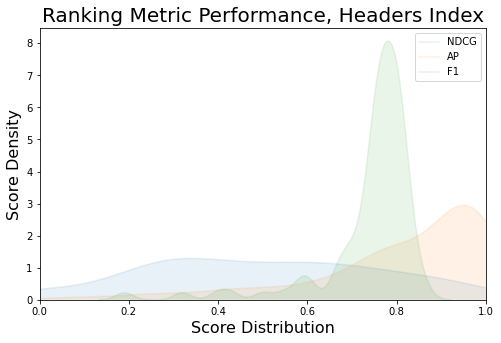

In [45]:
plt.figure(figsize = (8,5))
sns.kdeplot(unique_headers_eval.NDCG, alpha=.1, shade=True, label='NDCG')
sns.kdeplot(unique_headers_eval.AP, alpha=.1, shade=True,label='AP')
sns.kdeplot(unique_headers_eval.F1,  alpha=.1, shade=True,label='F1')
plt.legend()
plt.title('Ranking Metric Performance, Headers Index', fontsize=20)
plt.xlabel('Score Distribution', fontsize=16)
plt.ylabel('Score Density', fontsize=16)
plt.xlim(0,1);

### Which comments were scored poorly?

In [46]:
with open('expanded.json') as f1:
    comments = json.load(f1)

In [47]:
unique_headers_eval.query("NDCG == 0")

,NDCG,AP,F1
0110,0.0,1.0,0.791667
0126,0.0,1.0,0.791667
0240,0.0,1.0,0.791667
0256,0.0,1.0,0.791667
0287,0.0,1.0,0.791667
0408,0.0,1.0,0.791667
0467,0.0,1.0,0.791667


In [48]:
poorf1 = unique_headers_eval.query("F1 < 0.5").F1
poorf1

0212    0.400000
0326    0.320000
0357    0.428571
0386    0.190476
Name: F1, dtype: float64

In [49]:
poorndcg = unique_headers_eval.query("NDCG < 0.3 & NDCG > 0").NDCG
poorndcg

0002    0.232430
0004    0.232430
0006    0.232430
0007    0.232430
0016    0.232430
0077    0.285028
0115    0.232430
0138    0.285028
0189    0.289065
0191    0.232430
0233    0.232430
0234    0.285028
0243    0.232430
0254    0.232430
0265    0.232430
0297    0.289065
0304    0.285028
0419    0.285028
Name: NDCG, dtype: float64

In [50]:
poorf1_comments = {key:comment for key, comment in comments.items() if key[0:4] in poorf1}
{key:len(comment) for key, comment in poorf1_comments.items()}

{'0212_0': 5262,
 '0212_1': 4865,
 '0212_2': 4858,
 '0212_3': 3172,
 '0326_0': 5054,
 '0326_1': 5360,
 '0326_2': 4803,
 '0326_3': 4949,
 '0326_4': 4995,
 '0326_5': 4872,
 '0326_6': 5009,
 '0326_7': 5512,
 '0326_8': 5443,
 '0326_9': 5668,
 '0326_10': 3574,
 '0357_0': 4992,
 '0357_1': 5068,
 '0357_2': 5559,
 '0357_3': 6051,
 '0357_4': 5431,
 '0357_5': 5197,
 '0357_6': 5129,
 '0357_7': 4937,
 '0357_8': 5417,
 '0357_9': 5231,
 '0357_10': 2912,
 '0386_0': 5076,
 '0386_1': 4849,
 '0386_2': 6643,
 '0386_3': 4809,
 '0386_4': 5003,
 '0386_5': 5585,
 '0386_6': 4791,
 '0386_7': 5697,
 '0386_8': 4887,
 '0386_9': 6161,
 '0386_10': 5436,
 '0386_11': 5254,
 '0386_12': 5683,
 '0386_13': 5566,
 '0386_14': 4986,
 '0386_15': 4764,
 '0386_16': 5135,
 '0386_17': 5001,
 '0386_18': 6360,
 '0386_19': 6204,
 '0386_20': 5969,
 '0386_21': 5077,
 '0386_22': 5044,
 '0386_23': 5113,
 '0386_24': 4836,
 '0386_25': 4767,
 '0386_26': 5424,
 '0386_27': 4150}

In [51]:
poorf1_comments_truth = {key:matches for key, matches in truth_dict.items() if key in poorf1}
poorf1_comments_truth

{'0212': ['a2',
  'a3',
  'a4b',
  'a4c',
  'a5b',
  'a5c',
  'a5d',
  'a6b',
  'a6c',
  'a6d3',
  'a7',
  'b2a',
  'b2b',
  'c2',
  'c3a',
  'c3b',
  'd2',
  'd3b',
  'e2',
  'e3',
  'e5',
  'e6',
  'e7'],
 '0326': ['a2',
  'a3',
  'a4b',
  'a4c',
  'a5b',
  'a5c',
  'a5d',
  'a6b',
  'a7',
  'b2a',
  'b2b',
  'c2',
  'c3a',
  'c3b',
  'd2',
  'd3b',
  'd3c',
  'e2',
  'e3',
  'e4',
  'e5',
  'e6',
  'e7'],
 '0357': ['a3',
  'a4c',
  'a5b',
  'a5c',
  'a5d',
  'a6b',
  'a7',
  'b2a',
  'b2b',
  'c2',
  'c3b',
  'd2',
  'd3b',
  'd3c',
  'e2',
  'e3',
  'e4',
  'e5',
  'e6',
  'e7'],
 '0386': ['a2',
  'a3',
  'a4b',
  'a4c',
  'a5b',
  'a5c',
  'a5d',
  'a6b',
  'a6c',
  'a6d2',
  'a6d3',
  'a7',
  'b2a',
  'b2b',
  'c2',
  'c3a',
  'c3b',
  'd2',
  'd3b',
  'd3c',
  'd3d',
  'd4',
  'e2',
  'e3',
  'e4',
  'e5',
  'e6']}

In [52]:
poorndcg_comments = {key:comment for key, comment in comments.items() if key in poorndcg}
{key:len(comment) for key, comment in poorndcg_comments.items()}

{'0002': 1884,
 '0004': 1061,
 '0006': 517,
 '0007': 2686,
 '0016': 4034,
 '0077': 1641,
 '0115': 2041,
 '0191': 714,
 '0233': 665,
 '0265': 1512,
 '0297': 138,
 '0419': 333}

In [53]:
poorndcg_comments_truth = {key:matches for key, matches in truth_dict.items() if key in poorndcg}
poorndcg_comments_truth

{'0002': ['d2'],
 '0004': ['a7'],
 '0006': ['f'],
 '0007': ['e3'],
 '0016': ['e5'],
 '0077': ['e6', 'f'],
 '0115': ['e2'],
 '0138': ['a3', 'a5b'],
 '0189': ['e6'],
 '0191': ['a7'],
 '0233': ['a3'],
 '0234': ['e5', 'e7'],
 '0243': ['e5'],
 '0254': ['a3'],
 '0265': ['d2'],
 '0297': ['a5c'],
 '0304': ['e5', 'e7'],
 '0419': ['e5', 'e7']}

## Custom Headers Index Testing

In [72]:
with open('match_header_custom_results.json') as f:
    custom_header_results = json.load(f)

In [73]:
#tranlate ES keys to true rule section names, MAINTAINING ORDER
for key, value in custom_header_results.items():
    value_list = []
    for val_idx, score in value.items():
        for true_key in truth_keys:
            if true_key in val_idx and true_key not in value_list: 
                value_list.append(true_key)
        custom_header_results[key]={true_key: score for (val_idx, score), true_key in zip(value.items(),value_list)}     

### Normalize scores (divide by mean)

In [74]:
normalized_results = {}
for comment_idx, result in custom_header_results.items():
    score_mean = np.mean(list(result.values()))
    score_dict = {}
    for rule_idx, score in result.items():
        score_dict[rule_idx] = score/score_mean
    normalized_results[comment_idx] = score_dict

In [75]:
normalized_lists = {comment_idx:list(score_dict.items()) for comment_idx, score_dict in normalized_results.items()}

### Merge results for same comment chunks

In [76]:
merged_results = {}
for key in unique_truth_dict.keys():
    merged_list = []
    for comment_idx, result_list in normalized_lists.items():
        if key in comment_idx:
            merged_list.extend(result_list)
    merged_results[key] = merged_list
merged_results = {comment_idx:sorted(result, key=lambda x:x[1], reverse=True) for comment_idx, result in merged_results.items()}

In [77]:
for comment_idx, tup_list in merged_results.items():
    score_dict = {}
    for tup in tup_list:
        if tup[0] in score_dict.keys():
            score_dict[tup[0]] += tup[1]
        else:
            score_dict[tup[0]] = tup[1]
    merged_results[comment_idx] = score_dict

In [78]:
merged_results = {comment_idx:dict(sorted(result.items(), key = lambda x:x[1], reverse=True))\
                  for comment_idx, result in merged_results.items()}

### Sklearn

In [79]:
#create truth dict with values equal to sparse array length=29, binary
unique_truth_dict_all = unique_truth_dict.copy()
for key, value in unique_truth_dict.items():
    new_value_list = np.zeros(len(truth_keys))
    for val in value:
        for i in range(len(truth_keys)):
            if val == truth_keys[i]:
                new_value_list[i] = 1
    unique_truth_dict_all[key] = new_value_list

In [80]:
#create header results dict with values equal to sparse array length=29, (discounted and binary versions)
custom_header_results_all = custom_header_results.copy()
custom_binary_header_results_all = custom_header_results.copy()
for key, value in custom_header_results.items():
    new_value_list_discounted = np.zeros(len(truth_keys))
    new_value_list_binary = np.zeros(len(truth_keys))
    counter = 1
    for rule_section in value.keys():
        for i in range(len(truth_keys)):
            if rule_section == truth_keys[i]:
                counter += 1
                new_value_list_discounted[i] = 1/math.log(counter, 2)
                new_value_list_binary[i] = 1
    custom_header_results_all[key] = new_value_list_discounted
    custom_binary_header_results_all[key] = new_value_list_binary

In [81]:
custom_headers_ndcg = {}
custom_headers_ap = {}
custom_headers_f1 = {}
for (true_key, true_value), (es_key, es_value) in zip(unique_truth_dict_all.items(), custom_header_results_all.items()):
    custom_headers_ndcg[true_key] = ndcg_score([true_value], [es_value])
    custom_headers_ap[true_key] = average_precision_score(true_value, es_value, pos_label=0)
for (true_key, true_value), (es_key, es_value) in zip(unique_truth_dict_all.items(), custom_binary_header_results_all.items()):
    custom_headers_f1[true_key] = f1_score(true_value, es_value, zero_division=0, pos_label=0)

In [82]:
custom_headers_eval = pd.DataFrame(data=[custom_headers_ndcg, custom_headers_ap, custom_headers_f1]).T
custom_headers_eval = custom_headers_eval.rename({0:"NDCG", 1:"AP", 2:"F1"}, axis=1)

In [83]:
custom_headers_eval.describe()

,NDCG,AP,F1
count,94.000000,94.000000,94.000000
mean,0.501630,0.811213,0.743768
std,0.258456,0.202562,0.105294
min,0.000000,0.068966,0.181818
25%,0.295665,0.747843,0.731707
50%,0.508220,0.877718,0.765957
75%,0.697107,0.958766,0.808511
max,0.992879,1.000000,0.837209


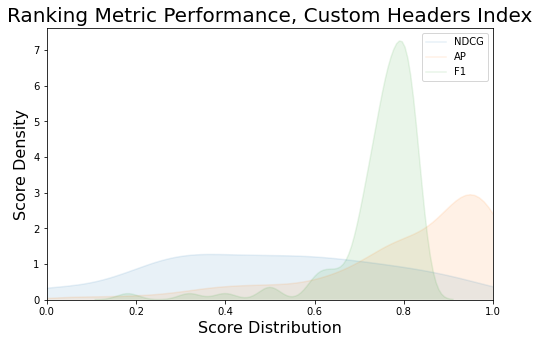

In [84]:
plt.figure(figsize = (8,5))
sns.kdeplot(custom_headers_eval.NDCG, alpha=.1, shade=True, label='NDCG')
sns.kdeplot(custom_headers_eval.AP, alpha=.1, shade=True,label='AP')
sns.kdeplot(custom_headers_eval.F1,  alpha=.1, shade=True,label='F1')
plt.legend()
plt.title('Ranking Metric Performance, Custom Headers Index', fontsize=20)
plt.xlabel('Score Distribution', fontsize=16)
plt.ylabel('Score Density', fontsize=16)
plt.xlim(0,1);

## Hybrid Unique Index Testing

In [85]:
with open('match_hybrid_results.json') as f1:
    unique_hybrid_results = json.load(f1)

In [86]:
#tranlate ES keys to true rule section names, MAINTAINING ORDER
for key, value in unique_hybrid_results.items():
    value_list = []
    for val_idx in value:
        for true_key in truth_keys:
            if true_key in val_idx[0:4]:
                    value_list.append(true_key)
        unique_hybrid_results[key]=[(true_key, score) for (val_idx, score), true_key in zip(value.items(),value_list)]

In [87]:
for comment_idx, tup_list in unique_hybrid_results.items():
    score_dict = {}
    for tup in tup_list:
        if tup[0] in score_dict.keys():
            score_dict[tup[0]] += tup[1]
        else:
            score_dict[tup[0]] = tup[1]
    unique_hybrid_results[comment_idx] = score_dict

### Normalize scores (divide by mean)

In [88]:
normalized_results = {}
for comment_idx, result in unique_hybrid_results.items():
    score_mean = np.mean(list(result.values()))
    score_dict = {}
    for rule_idx, score in result.items():
        score_dict[rule_idx] = score/score_mean
    normalized_results[comment_idx] = score_dict

In [89]:
normalized_lists = {comment_idx:list(score_dict.items()) for comment_idx, score_dict in normalized_results.items()}

### Merge results for same comment chunks

In [90]:
merged_results = {}
for key in unique_truth_dict.keys():
    merged_list = []
    for comment_idx, result_list in normalized_lists.items():
        if key in comment_idx:
            merged_list.extend(result_list)
    merged_results[key] = merged_list
merged_results = {comment_idx:sorted(result, key=lambda x:x[1], reverse=True) for comment_idx, result in merged_results.items()}

In [91]:
for comment_idx, tup_list in merged_results.items():
    score_dict = {}
    for tup in tup_list:
        if tup[0] in score_dict.keys():
            score_dict[tup[0]] += tup[1]
        else:
            score_dict[tup[0]] = tup[1]
    merged_results[comment_idx] = score_dict

In [92]:
merged_results = {comment_idx:dict(sorted(result.items(), key = lambda x:x[1], reverse=True))\
                  for comment_idx, result in merged_results.items()}

### Sklearn

In [93]:
#create truth dict with values equal to sparse array length=29, binary
unique_truth_dict_all = unique_truth_dict.copy()
for key, value in unique_truth_dict.items():
    new_value_list = np.zeros(len(truth_keys))
    for val in value:
        for i in range(len(truth_keys)):
            if val == truth_keys[i]:
                new_value_list[i] = 1
    unique_truth_dict_all[key] = new_value_list

In [94]:
#create header results dict with values equal to sparse array length=29, (discounted and binary versions)
unique_hybrid_results_all = unique_hybrid_results.copy()
unique_binary_hybrid_results_all = unique_hybrid_results.copy()
for key, value in unique_hybrid_results.items():
    new_value_list_discounted = np.zeros(len(truth_keys))
    new_value_list_binary = np.zeros(len(truth_keys))
    counter = 1
    for rule_section in value.keys():
        for i in range(len(truth_keys)):
            if rule_section == truth_keys[i]:
                counter += 1
                new_value_list_discounted[i] = 1/math.log(counter, 2)
                new_value_list_binary[i] = 1
    unique_hybrid_results_all[key] = new_value_list_discounted
    unique_binary_hybrid_results_all[key] = new_value_list_binary

In [95]:
unique_hybrid_ndcg = {}
unique_hybrid_ap = {}
unique_hybrid_f1 = {}
for (true_key, true_value), (es_key, es_value) in zip(unique_truth_dict_all.items(), unique_hybrid_results_all.items()):
    unique_hybrid_ndcg[true_key] = ndcg_score([true_value], [es_value])
    unique_hybrid_ap[true_key] = average_precision_score(true_value, es_value, pos_label=0)
for (true_key, true_value), (es_key, es_value) in zip(unique_truth_dict_all.items(), unique_binary_hybrid_results_all.items()):
    unique_hybrid_f1[true_key] = f1_score(true_value, es_value, zero_division=0, pos_label=0)

In [96]:
unique_hybrid_eval = pd.DataFrame(data=[unique_hybrid_ndcg, unique_hybrid_ap, unique_hybrid_f1]).T
unique_hybrid_eval = unique_hybrid_eval.rename({0:"NDCG", 1:"AP", 2:"F1"}, axis=1)

In [97]:
unique_hybrid_eval.describe()

,NDCG,AP,F1
count,94.000000,94.000000,94.000000
mean,0.487893,0.816932,0.815821
std,0.264448,0.201657,0.137985
min,0.000000,0.068966,0.153846
25%,0.262646,0.750801,0.795151
50%,0.490390,0.911137,0.857143
75%,0.696591,0.969212,0.901961
max,1.000000,1.000000,0.962963


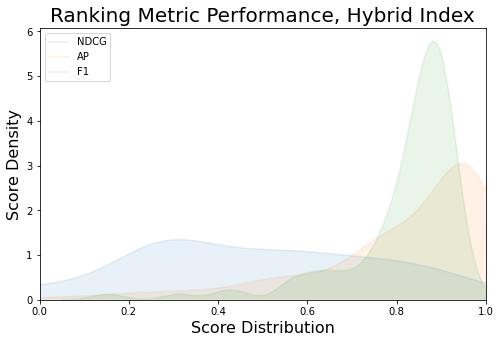

In [98]:
plt.figure(figsize = (8,5))
sns.kdeplot(unique_hybrid_eval.NDCG, alpha=.1, shade=True, label='NDCG')
sns.kdeplot(unique_hybrid_eval.AP, alpha=.1, shade=True,label='AP')
sns.kdeplot(unique_hybrid_eval.F1,  alpha=.1, shade=True,label='F1')
plt.legend()
plt.title('Ranking Metric Performance, Hybrid Index', fontsize=20)
plt.xlabel('Score Distribution', fontsize=16)
plt.ylabel('Score Density', fontsize=16)
plt.xlim(0,1);

### Which comments were scored poorly?

In [99]:
with open('expanded.json') as f1:
    comments = json.load(f1)

In [100]:
unique_hybrid_eval.query("NDCG == 0")

,NDCG,AP,F1
0110,0.0,1.0,0.925926
0126,0.0,1.0,0.925926
0240,0.0,1.0,0.884615
0256,0.0,1.0,0.925926
0287,0.0,1.0,0.905660
0408,0.0,1.0,0.905660
0467,0.0,1.0,0.884615


In [101]:
poorf1 = unique_hybrid_eval.query("F1 < 0.5").F1
poorf1

0212    0.444444
0326    0.312500
0357    0.411765
0386    0.153846
Name: F1, dtype: float64

In [102]:
poorndcg = unique_hybrid_eval.query("NDCG < 0.3 & NDCG > 0").NDCG
poorndcg

0002    0.250470
0004    0.238394
0005    0.238394
0006    0.262646
0007    0.255925
0008    0.241897
0016    0.262646
0042    0.250470
0115    0.255925
0189    0.255925
0191    0.245872
0205    0.255925
0233    0.255925
0243    0.255925
0254    0.262646
0265    0.250470
0271    0.250470
0297    0.255925
0385    0.241897
Name: NDCG, dtype: float64

In [103]:
poorf1_comments = {key:comment for key, comment in comments.items() if key[0:4] in poorf1}
{key:len(comment) for key, comment in poorf1_comments.items()}

{'0212_0': 5262,
 '0212_1': 4865,
 '0212_2': 4858,
 '0212_3': 3172,
 '0326_0': 5054,
 '0326_1': 5360,
 '0326_2': 4803,
 '0326_3': 4949,
 '0326_4': 4995,
 '0326_5': 4872,
 '0326_6': 5009,
 '0326_7': 5512,
 '0326_8': 5443,
 '0326_9': 5668,
 '0326_10': 3574,
 '0357_0': 4992,
 '0357_1': 5068,
 '0357_2': 5559,
 '0357_3': 6051,
 '0357_4': 5431,
 '0357_5': 5197,
 '0357_6': 5129,
 '0357_7': 4937,
 '0357_8': 5417,
 '0357_9': 5231,
 '0357_10': 2912,
 '0386_0': 5076,
 '0386_1': 4849,
 '0386_2': 6643,
 '0386_3': 4809,
 '0386_4': 5003,
 '0386_5': 5585,
 '0386_6': 4791,
 '0386_7': 5697,
 '0386_8': 4887,
 '0386_9': 6161,
 '0386_10': 5436,
 '0386_11': 5254,
 '0386_12': 5683,
 '0386_13': 5566,
 '0386_14': 4986,
 '0386_15': 4764,
 '0386_16': 5135,
 '0386_17': 5001,
 '0386_18': 6360,
 '0386_19': 6204,
 '0386_20': 5969,
 '0386_21': 5077,
 '0386_22': 5044,
 '0386_23': 5113,
 '0386_24': 4836,
 '0386_25': 4767,
 '0386_26': 5424,
 '0386_27': 4150}

In [104]:
poorf1_comments_truth = {key:matches for key, matches in truth_dict.items() if key in poorf1}
poorf1_comments_truth

{'0212': ['a2',
  'a3',
  'a4b',
  'a4c',
  'a5b',
  'a5c',
  'a5d',
  'a6b',
  'a6c',
  'a6d3',
  'a7',
  'b2a',
  'b2b',
  'c2',
  'c3a',
  'c3b',
  'd2',
  'd3b',
  'e2',
  'e3',
  'e5',
  'e6',
  'e7'],
 '0326': ['a2',
  'a3',
  'a4b',
  'a4c',
  'a5b',
  'a5c',
  'a5d',
  'a6b',
  'a7',
  'b2a',
  'b2b',
  'c2',
  'c3a',
  'c3b',
  'd2',
  'd3b',
  'd3c',
  'e2',
  'e3',
  'e4',
  'e5',
  'e6',
  'e7'],
 '0357': ['a3',
  'a4c',
  'a5b',
  'a5c',
  'a5d',
  'a6b',
  'a7',
  'b2a',
  'b2b',
  'c2',
  'c3b',
  'd2',
  'd3b',
  'd3c',
  'e2',
  'e3',
  'e4',
  'e5',
  'e6',
  'e7'],
 '0386': ['a2',
  'a3',
  'a4b',
  'a4c',
  'a5b',
  'a5c',
  'a5d',
  'a6b',
  'a6c',
  'a6d2',
  'a6d3',
  'a7',
  'b2a',
  'b2b',
  'c2',
  'c3a',
  'c3b',
  'd2',
  'd3b',
  'd3c',
  'd3d',
  'd4',
  'e2',
  'e3',
  'e4',
  'e5',
  'e6']}

In [105]:
poorndcg_comments = {key:comment for key, comment in comments.items() if key in poorndcg}
{key:len(comment) for key, comment in poorndcg_comments.items()}

{'0002': 1884,
 '0004': 1061,
 '0005': 3738,
 '0006': 517,
 '0007': 2686,
 '0008': 1419,
 '0016': 4034,
 '0042': 66,
 '0115': 2041,
 '0191': 714,
 '0205': 3954,
 '0233': 665,
 '0265': 1512,
 '0271': 1163,
 '0297': 138,
 '0385': 902}

In [106]:
poorndcg_comments_truth = {key:matches for key, matches in truth_dict.items() if key in poorndcg}
poorndcg_comments_truth

{'0002': ['d2'],
 '0004': ['a7'],
 '0005': ['a5b'],
 '0006': ['f'],
 '0007': ['e3'],
 '0008': ['c3b'],
 '0016': ['e5'],
 '0042': ['a5c'],
 '0115': ['e2'],
 '0189': ['e6'],
 '0191': ['a7'],
 '0205': ['b2b'],
 '0233': ['a3'],
 '0243': ['e5'],
 '0254': ['a3'],
 '0265': ['d2'],
 '0271': ['a5c'],
 '0297': ['a5c'],
 '0385': ['e3']}

## Hybrid Custom Index Testing

In [107]:
with open('match_hybrid_custom_results.json') as f1:
    custom_hybrid_results = json.load(f1)

In [108]:
#tranlate ES keys to true rule section names, MAINTAINING ORDER
for key, value in custom_hybrid_results.items():
    value_list = []
    for val_idx in value:
        for true_key in truth_keys:
            if true_key in val_idx[0:4]:
                    value_list.append(true_key)
        custom_hybrid_results[key]=[(true_key, score) for (val_idx, score), true_key in zip(value.items(),value_list)]

In [109]:
for comment_idx, tup_list in custom_hybrid_results.items():
    score_dict = {}
    for tup in tup_list:
        if tup[0] in score_dict.keys():
            score_dict[tup[0]] += tup[1]
        else:
            score_dict[tup[0]] = tup[1]
    custom_hybrid_results[comment_idx] = score_dict

### Normalize scores (divide by mean)

In [110]:
normalized_results = {}
for comment_idx, result in custom_hybrid_results.items():
    score_mean = np.mean(list(result.values()))
    score_dict = {}
    for rule_idx, score in result.items():
        score_dict[rule_idx] = score/score_mean
    normalized_results[comment_idx] = score_dict

In [111]:
normalized_lists = {comment_idx:list(score_dict.items()) for comment_idx, score_dict in normalized_results.items()}

### Merge results for same comment chunks

In [112]:
merged_results = {}
for key in unique_truth_dict.keys():
    merged_list = []
    for comment_idx, result_list in normalized_lists.items():
        if key in comment_idx:
            merged_list.extend(result_list)
    merged_results[key] = merged_list
merged_results = {comment_idx:sorted(result, key=lambda x:x[1], reverse=True) for comment_idx, result in merged_results.items()}

In [113]:
for comment_idx, tup_list in merged_results.items():
    score_dict = {}
    for tup in tup_list:
        if tup[0] in score_dict.keys():
            score_dict[tup[0]] += tup[1]
        else:
            score_dict[tup[0]] = tup[1]
    merged_results[comment_idx] = score_dict

In [114]:
merged_results = {comment_idx:dict(sorted(result.items(), key = lambda x:x[1], reverse=True))\
                  for comment_idx, result in merged_results.items()}

### Sklearn

In [115]:
#create truth dict with values equal to sparse array length=29, binary
unique_truth_dict_all = unique_truth_dict.copy()
for key, value in unique_truth_dict.items():
    new_value_list = np.zeros(len(truth_keys))
    for val in value:
        for i in range(len(truth_keys)):
            if val == truth_keys[i]:
                new_value_list[i] = 1
    unique_truth_dict_all[key] = new_value_list

In [116]:
#create header results dict with values equal to sparse array length=29, (discounted and binary versions)
custom_hybrid_results_all = custom_hybrid_results.copy()
custom_binary_hybrid_results_all = custom_hybrid_results.copy()
for key, value in custom_hybrid_results.items():
    new_value_list_discounted = np.zeros(len(truth_keys))
    new_value_list_binary = np.zeros(len(truth_keys))
    counter = 1
    for rule_section in value.keys():
        for i in range(len(truth_keys)):
            if rule_section == truth_keys[i]:
                counter += 1
                new_value_list_discounted[i] = 1/math.log(counter, 2)
                new_value_list_binary[i] = 1
    custom_hybrid_results_all[key] = new_value_list_discounted
    custom_binary_hybrid_results_all[key] = new_value_list_binary

In [117]:
custom_hybrid_ndcg = {}
custom_hybrid_ap = {}
custom_hybrid_f1 = {}
for (true_key, true_value), (es_key, es_value) in zip(unique_truth_dict_all.items(), custom_hybrid_results_all.items()):
    custom_hybrid_ndcg[true_key] = ndcg_score([true_value], [es_value])
    custom_hybrid_ap[true_key] = average_precision_score(true_value, es_value, pos_label=0)
for (true_key, true_value), (es_key, es_value) in zip(unique_truth_dict_all.items(), custom_binary_hybrid_results_all.items()):
    custom_hybrid_f1[true_key] = f1_score(true_value, es_value, zero_division=0, pos_label=0)

In [118]:
custom_hybrid_eval = pd.DataFrame(data=[custom_hybrid_ndcg, custom_hybrid_ap, custom_hybrid_f1]).T
custom_hybrid_eval = custom_hybrid_eval.rename({0:"NDCG", 1:"AP", 2:"F1"}, axis=1)

In [119]:
custom_hybrid_eval.describe()

,NDCG,AP,F1
count,94.000000,94.000000,94.000000
mean,0.485239,0.819608,0.809310
std,0.262184,0.196398,0.147469
min,0.000000,0.068966,0.148148
25%,0.272363,0.758470,0.808511
50%,0.478919,0.908873,0.862745
75%,0.694994,0.969212,0.884615
max,1.000000,1.000000,0.943396


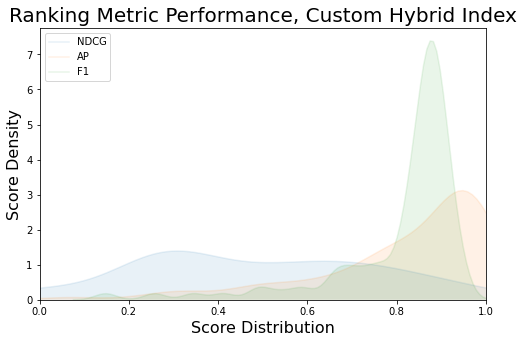

In [120]:
plt.figure(figsize = (8,5))
sns.kdeplot(custom_hybrid_eval.NDCG, alpha=.1, shade=True, label='NDCG')
sns.kdeplot(custom_hybrid_eval.AP, alpha=.1, shade=True,label='AP')
sns.kdeplot(custom_hybrid_eval.F1,  alpha=.1, shade=True,label='F1')
plt.legend()
plt.title('Ranking Metric Performance, Custom Hybrid Index', fontsize=20)
plt.xlabel('Score Distribution', fontsize=16)
plt.ylabel('Score Density', fontsize=16)
plt.xlim(0,1);